# Project: TMDb movie data

## Table of Contents
<ul>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#wrangling">Data Wrangling</a></li>
    <li><a href="#eda">Exploratory Data Analysis</a></li>
    <li><a href="#conclusions">Conclusions</a></li>
    <li><a href="#limitations">limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction

The data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

This project looks at the different perofrmance according to different gerne. It is important to know that every moive might have more than one genre.

In [1]:
# Import Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties
In the original dataset, there are 21 columns. Some of columns has multiple values such as genres, cast, production_companies.

In [2]:
# Import dataset
df = pd.read_csv('tmdb-movies.csv')
df.head(1)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [4]:
df.nunique()

id                      10865
imdb_id                 10855
popularity              10814
budget                    557
revenue                  4702
original_title          10571
cast                    10719
homepage                 2896
director                 5067
tagline                  7997
keywords                 8804
overview                10847
runtime                   247
genres                   2039
production_companies     7445
release_date             5909
vote_count               1289
vote_average               72
release_year               56
budget_adj               2614
revenue_adj              4840
dtype: int64

## Drop columns
There are 10 columns are dropped, being `id`, `imdb_id`, `budget`, `revenue`, `release_date`, `tagline`, `keywords`, `overview`, `production_companies`, `cast`, and `director`.

- The `id` and `imdb_id` is the identical information for each data, which is unnecessary in analysis.

- The `budget` and `revenue` columns are replaced by `budget_adj` and `revenue_adj` which account for inflation over the time and associated in terms of 2010 dolloars.

- The `release_date` is similar to `release_year`, therefore, only keep `relase_year` for analysis.

- The `tagline`, `keywords`, `overview`, `production_companies`, `cast`, `director` might be useful if using the natural language processing. It is dropped in this case study because they will create a significant number of features.


In [5]:
# Remove unnecessary columns
df.drop(columns=['id', 'imdb_id', 'budget', 'revenue', 'release_date', 'tagline', 'keywords', 'overview', 'production_companies', 'cast', 'director'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 10 columns):
popularity        10866 non-null float64
original_title    10866 non-null object
homepage          2936 non-null object
runtime           10866 non-null int64
genres            10843 non-null object
vote_count        10866 non-null int64
vote_average      10866 non-null float64
release_year      10866 non-null int64
budget_adj        10866 non-null float64
revenue_adj       10866 non-null float64
dtypes: float64(4), int64(3), object(3)
memory usage: 849.0+ KB


## Missing Data & Duplicate Data

Because the `homepage` has lots of missing data and every movie will have different web-page, it is replaced by `has_homepage` which shows the information about it has homepage or not.

Then drop the row with NaN values and duplicated data. 

After this process, there are 10842 rows with 10 features.

In [6]:
df['has_homepage'] = np.where(df['homepage'].isnull(), False, True)
df.drop(columns=['homepage'], inplace=True)

In [7]:
# Drop row with Nan
df.dropna(inplace=True)

In [8]:
# Drop Duplicated data
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(10842, 10)

## Genre modification

Create one column for each genre, and identiy the number of genre of each rows.
After this process, there are 31 columns

In [10]:
genre_df = df["genres"].str.get_dummies("|")
df = pd.concat([df, genre_df], axis=1)

genre_list = genre_df.columns.values
df['genre_num'] = df[genre_list].sum(axis=1)

In [11]:
df.columns

Index(['popularity', 'original_title', 'runtime', 'genres', 'vote_count',
       'vote_average', 'release_year', 'budget_adj', 'revenue_adj',
       'has_homepage', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'genre_num'],
      dtype='object')

<a id='eda'></a>
## Exploratory Data Analysis

### Question 1: The perofrmance of different genre in terms of revenue, budget, popularity, runtime, vote_count, vote_average,  homepage and genre_num

In [12]:
def average_genre(column, name):
    '''
    This function looks at the performance of different genre according to the different column.
    The column is the column_name in the dataset
    The name is the name of x_label
    '''
    
    average_genre = dict()
    for genre in genre_list:
        average_genre.update({genre:round(df[df[genre] == 1][column].mean(), 2)})

    average_genre = {k: v for k, v in sorted(average_genre.items(), key=lambda item: item[1])}
    plt.barh(range(len(average_genre)), average_genre.values(), align='center')
    plt.yticks(range(len(average_genre)), average_genre.keys())
    plt.xlabel('Average ' + name)
    plt.ylabel('Genre')
    plt.title('Average {} of different Genres'.format(name))
    plt.show()    

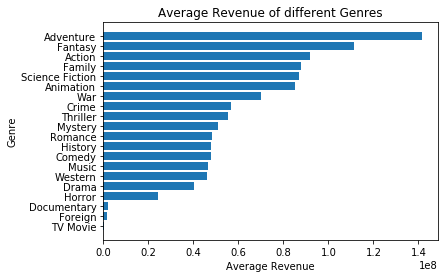

In [13]:
# Different genre and revenue
average_genre('revenue_adj', 'Revenue')

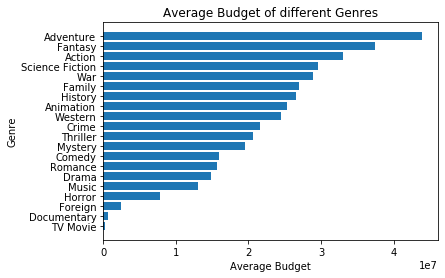

In [14]:
# Different genre and budget
average_genre('budget_adj', 'Budget')

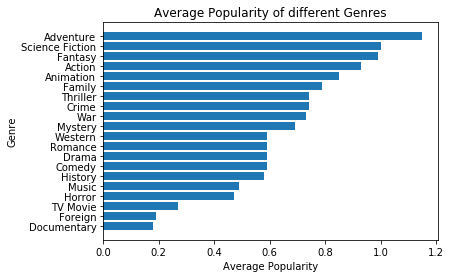

In [15]:
# Different genre and popularity
average_genre('popularity', 'Popularity')

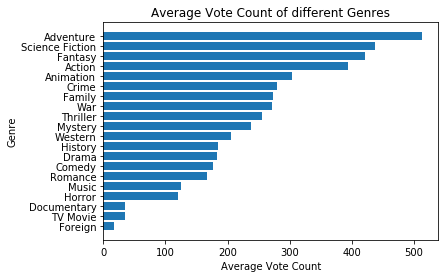

In [16]:
# Different genre and vote count
average_genre('vote_count', 'Vote Count')

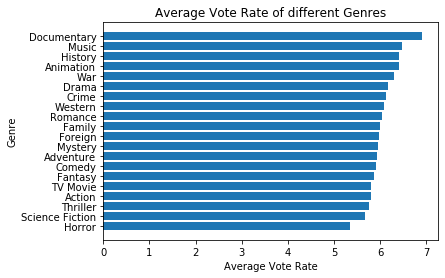

In [17]:
# Different genre and vote rate
average_genre('vote_average', 'Vote Rate')

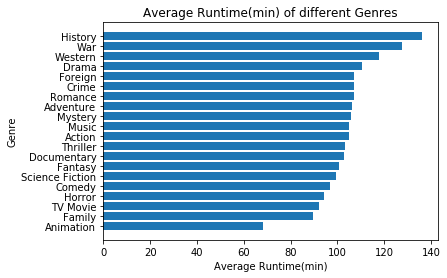

In [18]:
# Different genre and runtime
average_genre('runtime', 'Runtime(min)')

Text(0, 0.5, '')

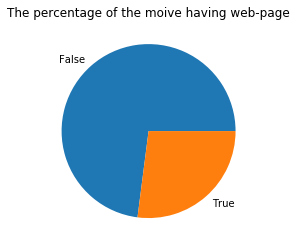

In [19]:
# The frequency of movie having web-page
df['has_homepage'].value_counts().plot(kind='pie')
plt.title('The percentage of the moive having web-page')
plt.ylabel('')

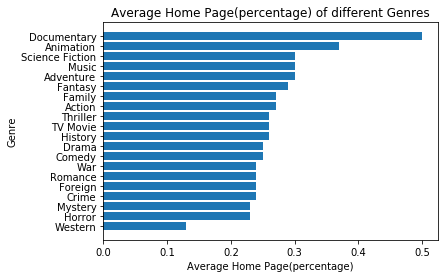

In [20]:
# Different genre and homepage
average_genre('has_homepage', 'Home Page(percentage)')

Text(0.5, 1.0, 'The frequency of the number of mixing genres')

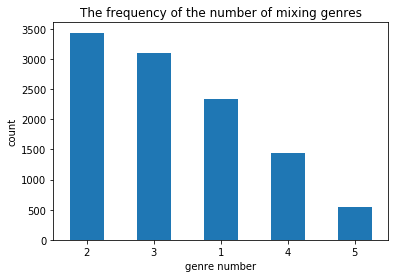

In [21]:
# The count of different genre
df['genre_num'].value_counts().plot(kind='bar')
plt.xlabel('genre number')
plt.xticks(rotation=360)
plt.ylabel('count')
plt.title('The frequency of the number of mixing genres')


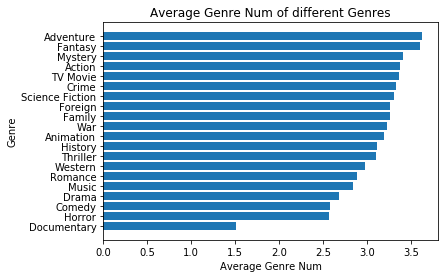

In [22]:
# Different genre and genre num
average_genre('genre_num', 'Genre Num')

## Question 2: Which kind of genre is used in most of movie

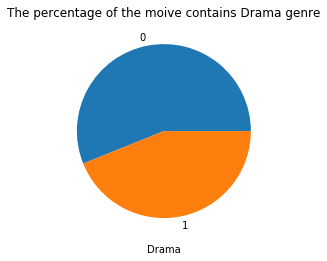

In [23]:
# Show the genre that is used in more than 40% of movies
for genre in genre_list:
    if(df[df[genre] == 1].shape[0]/df.shape[0] >= 0.4):
        df[genre].value_counts().plot(kind='pie')
        plt.title('The percentage of the moive contains {} genre'.format(genre))
        plt.ylabel('')
        plt.xlabel(genre)
        plt.show()

<a id='conclusions'></a>
## Conclusion

The revenue and budget is positive correlated in different genres. The genre with more budget tends to have higher revenue. The adventure movie has the highest revenue and budget and TV Moive has the lowest revenue and budge.

The popurlarity and vote_count is positive correlated. The Adventure moive is most popular and the documnemt moive is the least popular.

The vote is similar among different genres, which is range from 5 to 7.

The history movie has the highest average run time(140) and the animation movie has the lowest average run time(70). Most of run time of different genres fall between 80 - 120 mins.

Most of movies do not have web-pages(higher than 50%) while the documentary movie has 50% having web-pages.

Most of genres tends to mix 2-4 genres but the documentary movie only mix at most 2 moives in average. Most of movies have 2 genres(around 3500) and only around 500 movies have 5 genres.

The drama is used the most, more than 40% of movie contains drama.


<a id='limitations'></a>
## Limitations

Some of the columns are not be analysed. For example, the cast, director might have relationship with genres. Some of actors or directors might in favor of specific genres.